Using device: cuda
Number of classes: 38
Classes: ['Apple___Apple_scab', 'Apple___Black_rot', 'Apple___Cedar_apple_rust', 'Apple___healthy', 'Blueberry___healthy', 'Cherry_(including_sour)___Powdery_mildew', 'Cherry_(including_sour)___healthy', 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot', 'Corn_(maize)___Common_rust_', 'Corn_(maize)___Northern_Leaf_Blight', 'Corn_(maize)___healthy', 'Grape___Black_rot', 'Grape___Esca_(Black_Measles)', 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)', 'Grape___healthy', 'Orange___Haunglongbing_(Citrus_greening)', 'Peach___Bacterial_spot', 'Peach___healthy', 'Pepper,_bell___Bacterial_spot', 'Pepper,_bell___healthy', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'Raspberry___healthy', 'Soybean___healthy', 'Squash___Powdery_mildew', 'Strawberry___Leaf_scorch', 'Strawberry___healthy', 'Tomato___Bacterial_spot', 'Tomato___Early_blight', 'Tomato___Late_blight', 'Tomato___Leaf_Mold', 'Tomato___Septoria_leaf_spot', 'Tomato___Spider_m

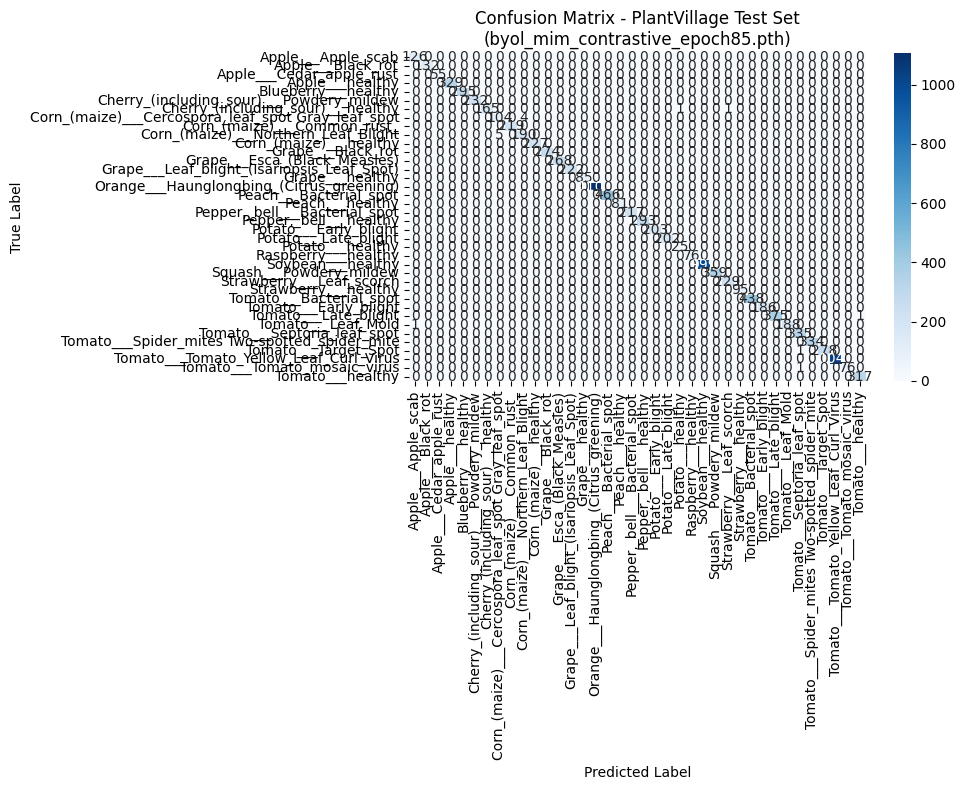

In [1]:
import random
import numpy as np
import torch
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, Subset
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
import seaborn as sns
import matplotlib.pyplot as plt
import os

# Set random seeds for reproducibility
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)  # If using multiple GPUs

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

##################################
# 1. Data Augmentations & Loaders
##################################
image_size = 384

# Training augmentations
train_transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.RandomApply([
       transforms.RandomRotation(15),
       transforms.RandomHorizontalFlip(),
       transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.1),
       transforms.RandomResizedCrop(image_size, scale=(0.8, 1.0))
    ], p=0.8),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Test/Validation augmentations
test_transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Path to your PlantVillage dataset
data_dir = '../PlantVillage-Dataset/raw/color'

# Create a full dataset without transforms first (to get indices)
full_dataset = datasets.ImageFolder(root=data_dir)
num_classes = len(full_dataset.classes)
class_names = full_dataset.classes
print("Number of classes:", num_classes)
print("Classes:", class_names)

# Partition the dataset into 80% train and 20% test
num_samples = len(full_dataset)
indices = list(range(num_samples))
# Ensure reproducibility
np.random.shuffle(indices)
split = int(np.floor(0.8 * num_samples))
train_indices, test_indices = indices[:split], indices[split:]

# Create training and testing datasets with their corresponding transforms
train_dataset = Subset(
    datasets.ImageFolder(root=data_dir, transform=train_transform),
    train_indices
)
test_dataset = Subset(
    datasets.ImageFolder(root=data_dir, transform=test_transform),
    test_indices
)

# Define DataLoaders
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

print(f"Dataset Loaded! {num_classes} classes found.")
print("Number of images in train_loader:", len(train_dataset))
print("Number of images in test_loader:", len(test_dataset))

##################################
# 2. Define the Model Architecture
##################################
# Define the same MLPClassifier as used in SSL pretraining
class MLPClassifier(nn.Module):
    def __init__(self, in_features, num_classes):
        super(MLPClassifier, self).__init__()
        self.classifier = nn.Sequential(
            nn.Linear(in_features, 512),
            nn.ReLU(),
            nn.Linear(512, num_classes)
        )
    def forward(self, x):
        return self.classifier(x)

def build_model():
    # Build the ResNet101 backbone and attach the custom classification head
    model = models.resnet101(weights=None)  # Start without pretrained weights
    model.fc = MLPClassifier(in_features=2048, num_classes=num_classes)
    return model

##################################
# 3. Setup Loss, Optimizer, and Scheduler Function
##################################
def setup_training(model, lr=1e-5):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=5e-5)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)
    return criterion, optimizer, scheduler

##################################
# 4. Fine-Tuning and Evaluation Function
##################################
def fine_tune_and_evaluate(checkpoint_path, num_finetune_epochs=60):
    print(f"\n=== Starting Fine-Tuning for Checkpoint: {checkpoint_path} ===")
    # Build model architecture
    model = build_model()
    pretrained_weights = torch.load(checkpoint_path, map_location=device)

    # Remove classifier head weights from the pretrained state_dict
    pretrained_weights_backbone = {
        k: v for k, v in pretrained_weights.items() if not k.startswith('fc.classifier')
    }

    # Load the backbone weights only, ignoring the mismatched classifier head
    missing_keys, unexpected_keys = model.load_state_dict(pretrained_weights_backbone, strict=False)
    if missing_keys:
        print("Missing keys (expected, due to different classification head):", missing_keys)
    if unexpected_keys:
        print("Unexpected keys:", unexpected_keys)

    print("Loaded SSL pre-trained backbone weights successfully.")
    model = model.to(device)

    criterion, optimizer, scheduler = setup_training(model, lr=1e-5)
    
    best_acc = 0.0

    # Rest of the fine-tuning loop remains unchanged
    for epoch in range(num_finetune_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            correct += preds.eq(labels).sum().item()
            total += labels.size(0)

        train_loss = running_loss / total
        train_acc = correct / total

        # Validation Loop
        model.eval()
        val_running_loss = 0.0
        val_correct = 0
        val_total = 0
        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_running_loss += loss.item() * images.size(0)
                _, preds = torch.max(outputs, 1)
                val_correct += preds.eq(labels).sum().item()
                val_total += labels.size(0)

        val_loss = val_running_loss / val_total
        val_acc = val_correct / val_total

        scheduler.step()

        print(f"Epoch [{epoch+1}/{num_finetune_epochs}] - "
              f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc*100:.2f}% | "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc*100:.2f}%")

        # Save best model if improved
        if val_acc > best_acc:
            best_acc = val_acc
            torch.save(model.state_dict(), f"plantvillage_best_finetuned_{checkpoint_path}.pth")
            print("Saved Best Model!")

    print("Fine-Tuning Complete!")

    # Evaluation on Test Set (remains unchanged)
    model.load_state_dict(torch.load(f"plantvillage_best_finetuned_{checkpoint_path}.pth"))
    model = model.to(device)
    model.eval()
    
    all_labels = []
    all_preds = []
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
    
    all_labels = np.array(all_labels)
    all_preds = np.array(all_preds)
    
    accuracy = (all_preds == all_labels).mean()
    macro_precision = precision_score(all_labels, all_preds, average='macro')
    macro_recall = recall_score(all_labels, all_preds, average='macro')
    macro_f1 = f1_score(all_labels, all_preds, average='macro')
    
    print("\n=== Final Evaluation for", checkpoint_path, "===")
    print(f"Accuracy  : {accuracy:.4f}")
    print(f"Precision : {macro_precision:.4f} (macro)")
    print(f"Recall    : {macro_recall:.4f} (macro)")
    print(f"F1-score  : {macro_f1:.4f} (macro)")
    
    # Plot and save Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=class_names, yticklabels=class_names)
    plt.title(f"Confusion Matrix - PlantVillage Test Set\n({checkpoint_path})")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.tight_layout()
    plt.show()


##################################
# 5. Loop Over Checkpoints for Classification
##################################
checkpoint_list = [
    "byol_mim_contrastive_epoch85.pth"
]

for ckpt in checkpoint_list:
    fine_tune_and_evaluate(ckpt, num_finetune_epochs=12)
